# Computation of virtual orbitals and check of the completeness relation for $CO$

We compute the virtual orbitals of the $CO$ molecule and evalute the maximum energy sampled by the system. Then we use this basis to express the occupied orbitals of the same molecule subjected to a static electric field.

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import json
import sys
sys.path.insert(0,'../../')
import Routine as R
outputpath = 'virtual-orbitals/'

Autosave disabled


First of all we define the python dictionary that contains the basic keys common to all the file in the run and we write these common variables in the default file

In [2]:
inp0 = {'dft' : 
        {'hgrids': 0.37,
         'gnrm_cv' : 1e-8,
         'itermax' : 100,
         'inputpsiid': 2},
        'posinp': 'CO_posinp.xyz'}
Yaml.dump(inp0,outputpath + 'default.yaml')

## Computation of the virtual orbitals

The aim of this computation is to produce the set of virtual orbitals, up to the highest value specified by the 'virtMax' parameter with a maximum residue of $1e^{-4}$. To obtain this result we produce a list of virtual orbitals denoted as 'virt'. virt contains a number of virtual orbitals higher than virtMax, because the last elements have a higher residue and are included only to improve the convergence of the lower ones.

In [3]:
rVal = [7.0,9.0,10.0]
virt = {}
for r in rVal:
    virt[r] = [16*i for i in range(1,21)]
    for rep in [288,304,320]:
        virt[r].append(rep)
print virt

{9.0: [16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 288, 304, 320], 10.0: [16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 288, 304, 320], 7.0: [16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 288, 304, 320]}


We build the input file:

In [5]:
for r in rVal:
    inp={'dft':{
          'rmult': [r, 9.0],
          'itermax_virt' : 100,
          'gnrm_cv_virt' : 1e-4},
         'output': {
          'orbitals' : 'binary',
          'verbosity' : 3}
        }
    inp['radical'] = 'Rmult_'+str(r)
    lrun=[]
    for n in virt[r]:
        inp['dft']['norbv'] = -n
        inpname = 'Rmult_'+str(r)+'_numVirt_'+str(n)
        Yaml.dump(inp,outputpath + inpname + '.yaml')
        lrun.append(inpname)
    Yaml.dump(lrun,outputpath+'runs_'+str(r))

and execute the computation via the run file:

In [4]:
import os
os.environ['BIGDFT_ROOT']='/bigdft/bin/'
code=C.SystemCalculator(omp=4,mpi=2)
%cd $outputpath
for r in rVal:
    code.run(run_name='runs_'+str(r),skip=True,outdir='./log/')
%cd ../

/LR-nb/POLARIZABILITY/CO/free-bc/virtual-orbitals
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -r runs_7.0 -d ./log/ -s Yes
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -r runs_9.0 -d ./log/ -s Yes
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -r runs_10.0 -d ./log/ -s Yes
/LR-nb/POLARIZABILITY/CO/free-bc


We read the log files associated to the highest number of virtual orbitals and organize them in the lists Data.

In [5]:
Data = []
%cd $outputpath
for r in rVal:
    spath = 'log/log-Rmult_'+str(r)+'_numVirt_'+str(virt[r][-1])+'.yaml'
    log = !ls $spath
    print log
    Data.append(lf.Logfile(log[0]))
%cd ..

/LR-nb/POLARIZABILITY/CO/free-bc/virtual-orbitals
['log/log-Rmult_7.0_numVirt_320.yaml']
['log/log-Rmult_9.0_numVirt_320.yaml']
['log/log-Rmult_10.0_numVirt_320.yaml']
/LR-nb/POLARIZABILITY/CO/free-bc


We extract the value of the residue od the each orbital and plot it (we also display the reference value)

In [6]:
residues = []
for d in Data:
    residues.append(d.log['Optimization of virtual orbitals'][-2]['Residues per orbital'])

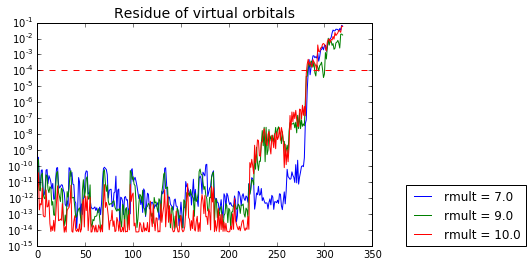

In [7]:
for r in range(len(rVal)):
    plt.plot(residues[r],label='rmult = '+str(rVal[r]))
plt.axhline(y=1e-4, color='r', linestyle='--')
plt.title('Residue of virtual orbitals',fontsize=14)
plt.yscale('log')
plt.legend(loc=(1.1,0.0))
plt.show()

On the basis of this plot we set the number of virtual orbitals with the chosen level of confidence

In [8]:
virtMax = []
errMax = 1e-4
for r in residues:
    notExcede = True
    i = 0
    while (notExcede):
        if r[i] > errMax:
            notExcede = False
        i+=1

    virtMax.append(i-2)
print 'virtMax = ', virtMax

virtMax =  [283, 282, 281]


We observe that the last computation performed is the one with the highest number of virtual orbitals, so the orbitals written on file are associated to this log, and we have to refer to it in order to correctly attribute energy and other paramters associated to them.

## Scaling of the energy vs. number of virtual orbitals

We build the array with the energy of the empty orbitals, up to virtMax. Results are expressed in eV

In [9]:
numOccOrb = 5
engVirt = []
for r in range(len(rVal)):
    print 'Rmult = ', rVal[r], 'virtMax = ', virtMax[r]
    eVirt = 27.211*Data[r].evals[0][0][numOccOrb:numOccOrb+virtMax[r]]
    engVirt.append([e for e in eVirt])

Rmult =  7.0 virtMax =  283
Rmult =  9.0 virtMax =  282
Rmult =  10.0 virtMax =  281


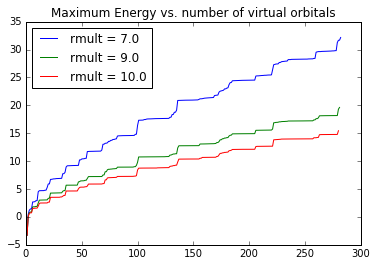

In [10]:
for r in range(len(rVal)):
    plt.plot(engVirt[r],label='rmult = '+str(rVal[r]))
plt.title('Maximum Energy vs. number of virtual orbitals',fontsize=12)
plt.legend(loc='best')
plt.show()

It is also interesting to compare the dos

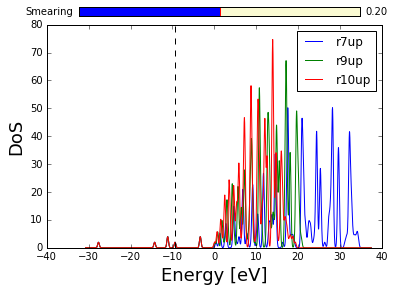

In [11]:
%matplotlib inline
dos=Data[0].get_dos(label='r7')
dos.append_from_bandarray(Data[1].evals,label='r9')
dos.append_from_bandarray(Data[2].evals,label='r10')
dos.plot()

In [27]:
# write engVirt on file
#%cd $outputpath
#f = open('engVirt.txt','w')
#json.dump(engVirt,f)
#f.close()
#%cd ../

## Expansion of the perturbed KS orbitals

We compute the projection of the KS orbitals for the ground state of the system under the action of a static electric field on the orbitals (both occupied and empty) computed here. We consider a field of norm $1e^{-2}$ both in the $z$ and $x$ directions. First of all we we build the input file, perform the computations and read the results.

### Generation of the input files and execution of the computations

In [28]:
for i,r in enumerate(rVal):
    psip_Ex = '../static-field/log/data-Ex_1em2_rmult_'+str(r) #relative path starting from outputpath
    psip_Ez = '../static-field/log/data-Ez_1em2_rmult_'+str(r)
    inpEx={'dft':
           {'rmult': [r, 9.0],
            'norbv': -virtMax[i],
            'itermax_virt' : 1},
           'output': {'orbitals' : 'No'},
           'radical': 'Rmult_'+str(r),
           'tddft':{'decompose_perturbation': psip_Ex}}
    inpEz={'dft':
           {'rmult': [r, 9.0],
            'norbv': -virtMax[i],
            'itermax_virt' : 1},
           'output': {'orbitals' : 'No'},
           'radical': 'Rmult_'+str(r),
           'tddft':{'decompose_perturbation': psip_Ez}}
    InpnameEx = 'CR_Ex_rmult_'+str(r)+'_numVirt_'+str(virtMax[i])
    InpnameEz = 'CR_Ez_rmult_'+str(r)+'_numVirt_'+str(virtMax[i])

    Yaml.dump(inpEz,outputpath + InpnameEz + '.yaml')
    Yaml.dump(inpEx,outputpath + InpnameEx + '.yaml')
    # execute the input files
    %cd $outputpath
    code.run(name=InpnameEx,skip=True,outdir='./log/')
    code.run(name=InpnameEz,skip=True,outdir='./log/')
    %cd ../



/LR-nb/POLARIZABILITY/CO/free-bc/virtual-orbitals
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -n CR_Ex_rmult_7.0_numVirt_283 -d ./log/ -s Yes
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -n CR_Ez_rmult_7.0_numVirt_283 -d ./log/ -s Yes
/LR-nb/POLARIZABILITY/CO/free-bc
/LR-nb/POLARIZABILITY/CO/free-bc/virtual-orbitals
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -n CR_Ex_rmult_9.0_numVirt_282 -d ./log/ -s Yes
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -n CR_Ez_rmult_9.0_numVirt_282 -d ./log/ -s Yes
/LR-nb/POLARIZABILITY/CO/free-bc
/LR-nb/POLARIZABILITY/CO/free-bc/virtual-orbitals
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -n CR_Ex_rmult_10.0_numVirt_281 -d ./log/ -s Yes
Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -n CR_Ez_rmult_10.0_numVirt_281 -d ./log/ -s Yes
/LR-nb/POLARIZABILITY/CO/free-bc


In [12]:
# read the data. First index for the value of rmult, second index for the direction of the field
CR_data = []
%cd $outputpath
for i,r in enumerate(rVal):
    spath = 'log/log-CR_E*_rmult_'+str(r)+'_numVirt_'+str(virtMax[i])+'.yaml'
    logs = !ls $spath
    print logs
    CR_data.append([lf.Logfile(l) for l in logs])
%cd ..

/LR-nb/POLARIZABILITY/CO/free-bc/virtual-orbitals
['log/log-CR_Ex_rmult_7.0_numVirt_283.yaml', 'log/log-CR_Ez_rmult_7.0_numVirt_283.yaml']
['log/log-CR_Ex_rmult_9.0_numVirt_282.yaml', 'log/log-CR_Ez_rmult_9.0_numVirt_282.yaml']
['log/log-CR_Ex_rmult_10.0_numVirt_281.yaml', 'log/log-CR_Ez_rmult_10.0_numVirt_281.yaml']
/LR-nb/POLARIZABILITY/CO/free-bc


The element [i,j] of coeff_occ[n] contains the projection of the j-th perturbed (occupied) orbital on the i-th unperturbed (occupied) one. In the same way but with the opposite convention, coeff_vrt contains the projection of the i-th perturbed (occupied) orbital on the j-th unperturbed empty one

### Assessment of the completeness of the basis

In [13]:
reload(R)
S_nvirt_Ex = []
S_nvirt_Ez = []
for r in range(len(rVal)):
    S_nvirt_Ex.append(R.evalS_nvirt(CR_data[r][0]))
    S_nvirt_Ez.append(R.evalS_nvirt(CR_data[r][1]))

no_occ 5 n_vrt 283
R =  0.00055262144699
no_occ 5 n_vrt 283
R =  0.000718595016691
no_occ 5 n_vrt 282
R =  0.000553348302283
no_occ 5 n_vrt 282
R =  0.000719907401896
no_occ 5 n_vrt 281
R =  0.00055336355888
no_occ 5 n_vrt 281
R =  0.000719935120111


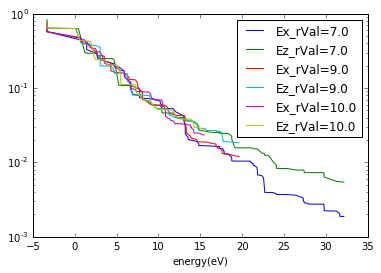

In [16]:
for r in range(len(rVal)): 
    plt.semilogy(engVirt[r],S_nvirt_Ex[r],label='Ex_rVal='+str(rVal[r]))
    plt.semilogy(engVirt[r],S_nvirt_Ez[r],label='Ez_rVal='+str(rVal[r]))
plt.xlabel('energy(eV)')
plt.legend(loc='best')
plt.show()

In [21]:
# write S_nvirt_Ex and S_nvirt_Ez on file (for rmult = 7.0)
#r = 0
#S_nvirt_Ex = R.evalS_nvirt(CR_data[r][0])
#S_nvirt_Ez = R.evalS_nvirt(CR_data[r][1])
#%cd $outputpath
#f = open('S_nvirt_Ex.txt','w')
#json.dump(S_nvirt_Ex,f)
#f.close()
#f = open('S_nvirt_Ez.txt','w')
#json.dump(S_nvirt_Ez,f)
#f.close()
#%cd ../

no_occ 5 n_vrt 303
R =  0.000371753750386
no_occ 5 n_vrt 303
R =  0.000533261680008
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2
